In [1]:
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
bpath = '/dados/das/pesq1/BAM.berror/xc50/old/'

#bfile = 'gsir4.berror_stats.gcv.BAM.TQ0062L028'
#bfile = 'gsir4.berror_stats.gcv.BAM.TQ0254L064'
#bfile = 'gsir4.berror_stats.gcv.BAM.TQ0299L064'
#bfile = 'gsir4.berror_stats.gcv'
#bfile = 'new_gsir4.berror_stats-tese-cfbastarz2017.gcv'
bfile = 'global_berror.l64y386.f77-ncep-dtc.gcv'

f = os.path.join(bpath, bfile)

In [4]:
def fopen(f):
    dt = np.dtype([ ('grid', '3>i4') ])

    with open(f, 'rb') as ftmp:
        tmp = np.fromfile(ftmp, dtype=dt, count=3, offset=4)  
        
    nsig = tmp[0]['grid'][0]
    nlat = tmp[0]['grid'][1]
    nlon = tmp[0]['grid'][2]
    
    print(nsig, nlat, nlon)
    
    grid = (nsig, nlat, nlon)
    
    # Define os tamanhos dos records dentro do arquivo ('>f4' indica floats de 32 bits, big endian)   
    tnlat = str(nlat) + '>f4'
    s2d = str(nlat*nsig) + '>f4'
    sst2d = str(nlat*nlon) + '>f4'
    s3d = str(nlat*nsig*nsig) + '>f4'

    # Define a estrutura e o tamanho do records dentro do arquivo    
    dt =          [ ('grid', '3>i4'), 
                   
                        ('pad1', '>i4'), ('agvin',s3d), 
                        ('pad2', '>i4'), ('bgvin', s2d),
                        ('pad3', '>i4'), ('wgvin', s2d), 
                       
                        ('pad4', '>i4'), ('sf', '|a5'), ('sig_sf', '>i4'), ('pad5', '>i4'), 
                        ('pad6', '>i4'), ('corzin_sf', s2d), ('pad7', '>i4'), 
                        ('pad8', '>i4'), ('hscalesin_sf', s2d), ('pad9', '>i4'), 
                        ('pad10', '>i4'), ('vscalesin_sf', s2d), ('pad11', '>i4'), 
                   
                        ('pad12', '>i4'), ('vp', '|a5'), ('sig_vp', '>i4'), ('pad13', '>i4'),
                        ('pad14', '>i4'), ('corzin_vp', s2d), ('pad15', '>i4'), 
                        ('pad16', '>i4'), ('hscalesin_vp', s2d), ('pad17', '>i4'), 
                        ('pad18', '>i4'), ('vscalesin_vp', s2d), ('pad19', '>i4'), 
                   
                        ('pad20', '>i4'), ('t', '|a5'), ('sig_t', '>i4'), ('pad21', '>i4'),
                        ('pad22', '>i4'), ('corzin_t', s2d), ('pad23', '>i4'), 
                        ('pad24', '>i4'), ('hscalesin_t', s2d), ('pad25', '>i4'), 
                        ('pad26', '>i4'), ('vscalesin_t', s2d), ('pad27', '>i4'), 
                   
                        ('pad28', '>i4'), ('q', '|a5'), ('sig_q', '>i4'), ('pad29', '>i4'),
                        ('pad30', '>i4'), ('corzin_q', s2d), ('corqin_q', s2d), ('pad31', '>i4'), 
                        ('pad32', '>i4'), ('hscalesin_q', s2d), ('pad33', '>i4'), 
                        ('pad34', '>i4'), ('vscalesin_q', s2d), ('pad35', '>i4'), 
                   
                        ('pad36', '>i4'), ('oz', '|a5'), ('sig_oz', '>i4'), ('pad37', '>i4'),
                        ('pad38', '>i4'), ('corzin_oz', s2d), ('pad39', '>i4'), 
                        ('pad40', '>i4'), ('hscalesin_oz', s2d), ('pad41', '>i4'), 
                        ('pad42', '>i4'), ('vscalesin_oz', s2d), ('pad43', '>i4'), 
                                      
                        ('pad44', '>i4'), ('cw', '|a5'), ('sig_cw', '>i4'), ('pad45', '>i4'),
                        ('pad46', '>i4'), ('corzin_cw', s2d), ('pad47', '>i4'), 
                        ('pad48', '>i4'), ('hscalesin_cw', s2d), ('pad49', '>i4'), 
                        ('pad50', '>i4'), ('vscalesin_cw', s2d), ('pad51', '>i4'), 
                   
                        ('pad52', '>i4'), ('ps', '|a5'), ('sig_ps', '>i4'), ('pad53', '>i4'), 
                        ('pad54', '>i4'), ('corpin_ps', tnlat), ('pad55', '>i4'), 
                        ('pad56', '>i4'), ('hscalespin_ps', tnlat), ('pad57', '>i4'), 
                   
                        ('pad58', '>i4'), ('sst', '|a5'), ('sig_sst', '>i4'), ('pad59', '>i4'),
                        ('pad60', '>i4'), ('corsstin_sst', sst2d), ('pad61', '>i4'), 
                        ('pad62', '>i4'), ('hsstin_ps', sst2d), ('pad63', '>i4') ]   
    
    dt_obj = np.dtype(dt)#, align=True)
    
    with open(f, 'rb') as ftmp:
        tmp2 = np.fromfile(ftmp, dtype=dt_obj, count=-1, offset=4) # count=-1 lê todo o arquivo
    
    return tmp2, grid
    
def latlonlev(grid):
    nsig = grid[0]
    nlat = grid[1]
    nlon = grid[2]
    
    lats = np.linspace(-90,90, nlat)
    lons = np.linspace(0,360, nlon)
    levs = np.arange(1, nsig+1)

    return nlat, nlon, nsig, lats, lons, levs
    
def balprojs(tmp, grid):   
    nlat, nlon, nsig, lats, lons, levs = latlonlev(grid)
    
    lbprojs = []
    
    agvin = np.reshape(tmp[0]['agvin'], (nlat, nsig, nsig), order='F')
    da_agvin = xr.DataArray(agvin, dims=['latitude', 'sigma', 'sigma_2'], coords={'latitude':lats, 'sigma':levs, 'sigma_2':levs})
    da_agvin = da_agvin.transpose('sigma', 'latitude', 'sigma_2')
    da_agvin = da_agvin.rename('agvin')

    lbprojs.append(da_agvin)
    
    bgvin = np.reshape(tmp[0]['bgvin'], (nlat, nsig), order='F')
    da_bgvin = xr.DataArray(bgvin, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_bgvin = da_bgvin.transpose('sigma', 'latitude')
    da_bgvin = da_bgvin.rename('bgvin')

    lbprojs.append(da_bgvin)
    
    wgvin = np.reshape(tmp[0]['wgvin'], (nlat, nsig), order='F')
    da_wgvin = xr.DataArray(wgvin, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_wgvin = da_wgvin.transpose('sigma', 'latitude')
    da_wgvin = da_wgvin.rename('wgvin')
    
    lbprojs.append(da_wgvin)
       
    return lbprojs

def amplitudes(tmp, grid):
    nlat, nlon, nsig, lats, lons, levs = latlonlev(grid)
        
    lamplitudes = []    
        
    corzin_sf = np.reshape(tmp[0]['corzin_sf'], (nlat, nsig), order='F')
    da_corzin_sf = xr.DataArray(corzin_sf, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_sf = da_corzin_sf.transpose('sigma', 'latitude')
    da_corzin_sf = da_corzin_sf.rename('corzinsf')
    
    lamplitudes.append(da_corzin_sf)
    
    corzin_vp = np.reshape(tmp[0]['corzin_vp'], (nlat, nsig), order='F')
    da_corzin_vp = xr.DataArray(corzin_vp, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_vp = da_corzin_vp.transpose('sigma', 'latitude')
    da_corzin_vp = da_corzin_vp.rename('corzinvp')
    
    lamplitudes.append(da_corzin_vp)
    
    corzin_t = np.reshape(tmp[0]['corzin_t'], (nlat, nsig), order='F')
    da_corzin_t = xr.DataArray(corzin_t, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_t = da_corzin_t.transpose('sigma', 'latitude')
    da_corzin_t = da_corzin_t.rename('corzint')
    
    lamplitudes.append(da_corzin_t)
    
    corzin_q = np.reshape(tmp[0]['corzin_q'], (nlat, nsig), order='F')
    da_corzin_q = xr.DataArray(corzin_q, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_q = da_corzin_q.transpose('sigma', 'latitude')
    da_corzin_q = da_corzin_q.rename('corzinq')
    
    lamplitudes.append(da_corzin_q)
    
    corqin_q = np.reshape(tmp[0]['corqin_q'], (nlat, nsig), order='F')
    da_corqin_q = xr.DataArray(corqin_q, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corqin_q = da_corqin_q.transpose('sigma', 'latitude')
    da_corqin_q = da_corqin_q.rename('corqinq')
    
    lamplitudes.append(da_corqin_q)
    
    corzin_oz = np.reshape(tmp[0]['corzin_oz'], (nlat, nsig), order='F')
    da_corzin_oz = xr.DataArray(corzin_oz, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_oz = da_corzin_oz.transpose('sigma', 'latitude')
    da_corzin_oz = da_corzin_oz.rename('corzinoz')
    
    lamplitudes.append(da_corzin_oz)
    
    corpin_ps = np.reshape(tmp[0]['corpin_ps'], (nlat), order='F')
    da_corpin_ps = xr.DataArray(corpin_ps, dims=['latitude'], coords={'latitude':lats})
    da_corpin_ps = da_corpin_ps.rename('corpinps')
    
    lamplitudes.append(da_corpin_ps)
    
    corzin_cw = np.reshape(tmp[0]['corzin_cw'], (nlat, nsig), order='F')
    da_corzin_cw = xr.DataArray(corzin_cw, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_corzin_cw = da_corzin_cw.transpose('sigma', 'latitude')
    da_corzin_cw = da_corzin_cw.rename('corzincw')
    
    lamplitudes.append(da_corzin_cw)
    
    corsstin_sst = np.reshape(tmp[0]['corsstin_sst'], (nlat, nlon), order='F')
    da_corsstin_sst = xr.DataArray(corsstin_sst, dims=['latitude', 'longitude'], coords={'latitude':lats, 'longitude':lons})
    da_corsstin_sst = da_corsstin_sst.rename('corsstinsst')
    
    lamplitudes.append(da_corsstin_sst)
    
    return lamplitudes

def hscales(tmp, grid):
    nlat, nlon, nsig, lats, lons, levs = latlonlev(grid)
        
    lhscales = []    
        
    hscalesin_sf = np.reshape(tmp[0]['hscalesin_sf'], (nlat, nsig), order='F')
    da_hscalesin_sf = xr.DataArray(hscalesin_sf, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_sf = da_hscalesin_sf.transpose('sigma', 'latitude')
    da_hscalesin_sf = da_hscalesin_sf.rename('hscalesinsf')
    
    lhscales.append(da_hscalesin_sf)
        
    hscalesin_vp = np.reshape(tmp[0]['hscalesin_vp'], (nlat, nsig), order='F')
    da_hscalesin_vp = xr.DataArray(hscalesin_vp, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_vp = da_hscalesin_vp.transpose('sigma', 'latitude')
    da_hscalesin_vp = da_hscalesin_vp.rename('hscalesinvp')
    
    lhscales.append(da_hscalesin_vp)
        
    hscalesin_t = np.reshape(tmp[0]['hscalesin_t'], (nlat, nsig), order='F')
    da_hscalesin_t = xr.DataArray(hscalesin_t, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_t = da_hscalesin_t.transpose('sigma', 'latitude')
    da_hscalesin_t = da_hscalesin_t.rename('hscalesint')
    
    lhscales.append(da_hscalesin_t)
        
    hscalesin_q = np.reshape(tmp[0]['hscalesin_q'], (nlat, nsig), order='F')
    da_hscalesin_q = xr.DataArray(hscalesin_q, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_q = da_hscalesin_q.transpose('sigma', 'latitude')
    da_hscalesin_q = da_hscalesin_q.rename('hscalesinq')
    
    lhscales.append(da_hscalesin_q)
        
    hscalesin_oz = np.reshape(tmp[0]['hscalesin_oz'], (nlat, nsig), order='F')
    da_hscalesin_oz = xr.DataArray(hscalesin_oz, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_oz = da_hscalesin_oz.transpose('sigma', 'latitude')
    da_hscalesin_oz = da_hscalesin_oz.rename('hscalesinoz')
    
    lhscales.append(da_hscalesin_oz)
        
    hscalesin_cw = np.reshape(tmp[0]['hscalesin_cw'], (nlat, nsig), order='F')
    da_hscalesin_cw = xr.DataArray(hscalesin_cw, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_hscalesin_cw = da_hscalesin_cw.transpose('sigma', 'latitude')
    da_hscalesin_cw = da_hscalesin_cw.rename('hscalesincw')
    
    lhscales.append(da_hscalesin_cw)
        
    hscalespin_ps = np.reshape(tmp[0]['hscalespin_ps'], (nlat), order='F')
    da_hscalespin_ps = xr.DataArray(hscalespin_ps, dims=['latitude'], coords={'latitude':lats})
    da_hscalespin_ps = da_hscalespin_ps.rename('hscalesinps')
    
    lhscales.append(da_hscalespin_ps)
        
    hsstin_ps = np.reshape(tmp[0]['hsstin_ps'], (nlat, nlon), order='F')
    da_hsstin_ps = xr.DataArray(hsstin_ps, dims=['latitude', 'longitude'], coords={'latitude':lats, 'longitude':lons})
    da_hsstin_ps = da_hsstin_ps.rename('hscalesinsst')
    
    lhscales.append(da_hsstin_ps)
        
    return lhscales
    
def vscales(tmp, grid):
    nlat, nlon, nsig, lats, lons, levs = latlonlev(grid)

    lvscales = []
    
    vscalesin_sf = np.reshape(tmp[0]['vscalesin_sf'], (nlat, nsig), order='F')
    da_vscalesin_sf = xr.DataArray(vscalesin_sf, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_sf = da_vscalesin_sf.transpose('sigma', 'latitude')
    da_vscalesin_sf = da_vscalesin_sf.rename('vscalesinsf')
    
    lvscales.append(da_vscalesin_sf)
    
    vscalesin_vp = np.reshape(tmp[0]['vscalesin_vp'], (nlat, nsig), order='F')
    da_vscalesin_vp = xr.DataArray(vscalesin_vp, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_vp = da_vscalesin_vp.transpose('sigma', 'latitude')
    da_vscalesin_vp = da_vscalesin_vp.rename('vscalesinvp')
    
    lvscales.append(da_vscalesin_vp)
    
    vscalesin_t = np.reshape(tmp[0]['vscalesin_t'], (nlat, nsig), order='F')
    da_vscalesin_t = xr.DataArray(vscalesin_t, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_t = da_vscalesin_t.transpose('sigma', 'latitude')
    da_vscalesin_t = da_vscalesin_t.rename('vscalesint')
    
    lvscales.append(da_vscalesin_t)
      
    vscalesin_q = np.reshape(tmp[0]['vscalesin_q'], (nlat, nsig), order='F')
    da_vscalesin_q = xr.DataArray(vscalesin_q, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_q = da_vscalesin_q.transpose('sigma', 'latitude')
    da_vscalesin_q = da_vscalesin_q.rename('vscalesinq')
    
    lvscales.append(da_vscalesin_q)
    
    vscalesin_oz = np.reshape(tmp[0]['vscalesin_oz'], (nlat, nsig), order='F')
    da_vscalesin_oz = xr.DataArray(vscalesin_oz, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_oz = da_vscalesin_oz.transpose('sigma', 'latitude')
    da_vscalesin_oz = da_vscalesin_oz.rename('vscalesinoz')
    
    lvscales.append(da_vscalesin_oz)
    
    vscalesin_cw = np.reshape(tmp[0]['vscalesin_cw'], (nlat, nsig), order='F')
    da_vscalesin_cw = xr.DataArray(vscalesin_cw, dims=['latitude', 'sigma'], coords={'latitude':lats, 'sigma':levs})
    da_vscalesin_cw = da_vscalesin_cw.transpose('sigma', 'latitude')
    da_vscalesin_cw = da_vscalesin_cw.rename('vscalesincw')
    
    lvscales.append(da_vscalesin_cw)
    
    return lvscales

def mplot(llist, ptype):
    if type(llist) is not list:
        llist_ = []
        llist_.append(llist)
    else:
        llist_ = llist.copy()
            
    size = len(llist_)
    lsize = enumerate(list(range(size)))
    
    if size == 1:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)
    elif size == 3:
        fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(16,4))
    elif size % 2 == 0:
        fig, ax = plt.subplots(int(size/2), 2, constrained_layout=True, figsize=(10,10))
    else:
        fig, ax = plt.subplots(int(size/2+1), 2, constrained_layout=True, figsize=(10,10))       
 
    i = 0 
    for item in llist_:
        if size == 1:
            axs = ax
        else:
            axs = ax.flat[i]
            
        if ptype == '2d':
            if len(item.dims) == 3:
                item.isel(sigma_2=0).plot.contourf(cmap='RdBu_r', ax=axs)
            elif len(item.dims) == 1:
                item.plot(ax=axs)
            else:
                item.plot.contourf(cmap='RdBu_r', ax=axs)       
            i += 1
        else:
            if 'sst' not in item.name:
                if len(item.dims) == 3:
                    item.isel(sigma_2=0).mean('latitude').plot(y='sigma', ax=axs)
                elif len(item.dims) == 1:
                    item.plot(ax=axs)
                else:
                    item.mean('latitude').plot(y='sigma', ax=axs)  
            else:
                fig.delaxes(ax=axs)
            i += 1 

    # Remove figuras vazias
    if size > 3 and size % 2 != 0:
        for l in ax.flat[i].get_xaxis().get_majorticklabels():
            l.set_visible(True)
        fig.delaxes(ax.flat[i])
    
    #if size > 1:
    #    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    
    return

In [5]:
tmp, grid = fopen(f)

64 386 768


In [6]:
lbprojs = balprojs(tmp, grid)

In [7]:
lamplitudes = amplitudes(tmp, grid)

In [8]:
lhscales = hscales(tmp, grid)

In [9]:
lvscales = vscales(tmp, grid)

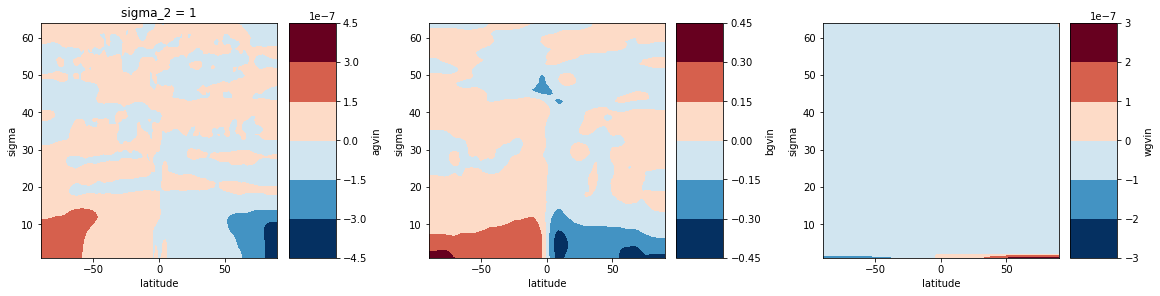

In [10]:
mplot(lbprojs, '2d')

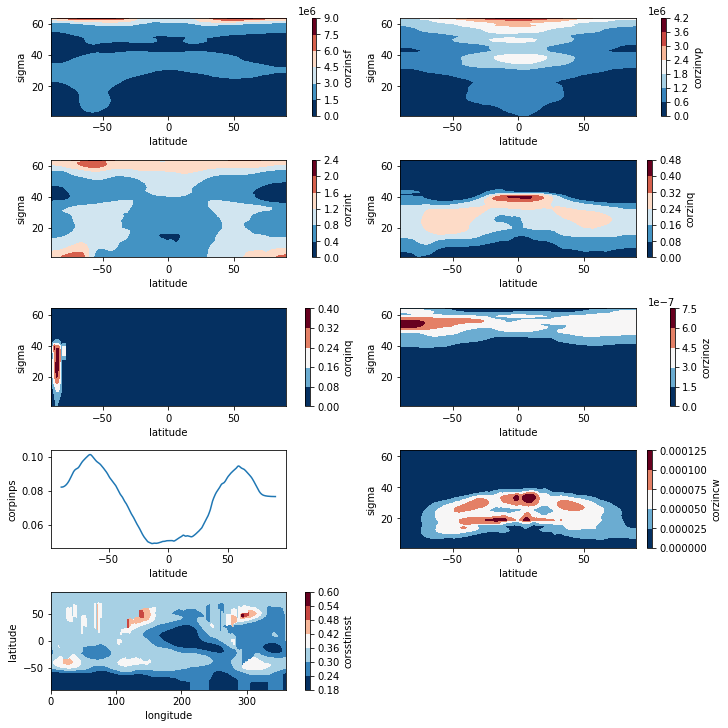

In [11]:
mplot(lamplitudes, '2d')

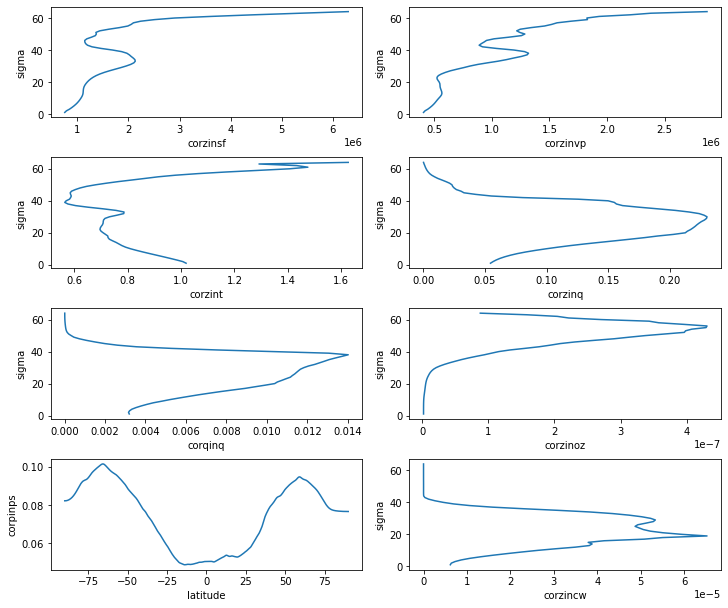

In [12]:
mplot(lamplitudes, '1d')

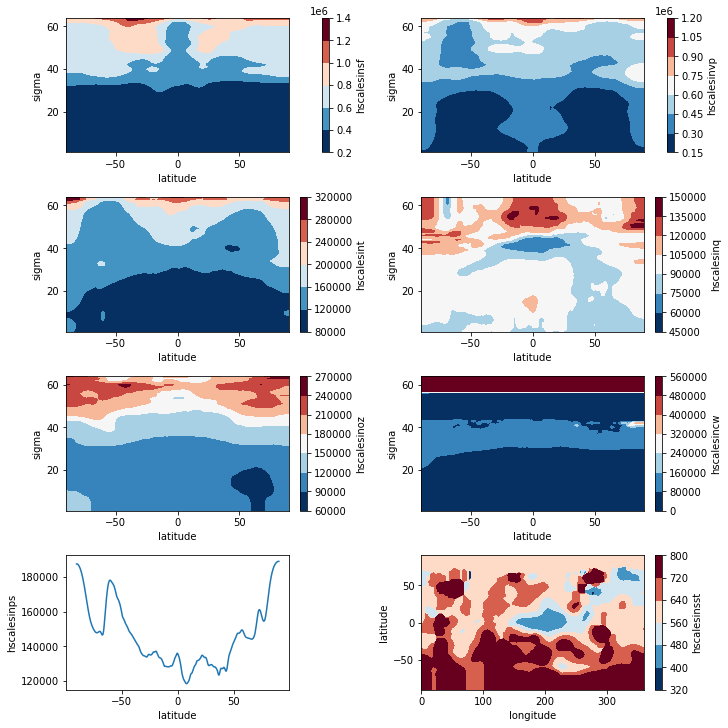

In [13]:
mplot(lhscales, '2d')

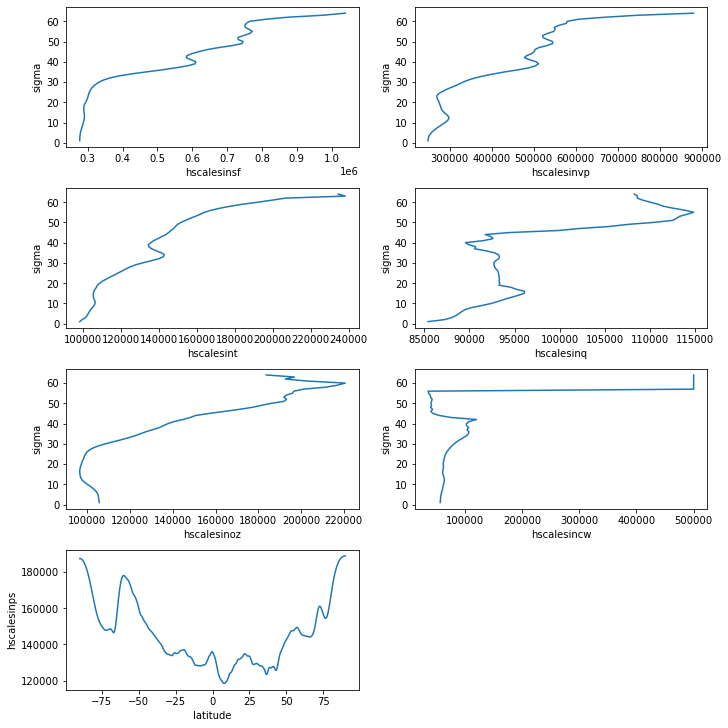

In [14]:
mplot(lhscales, '1d')

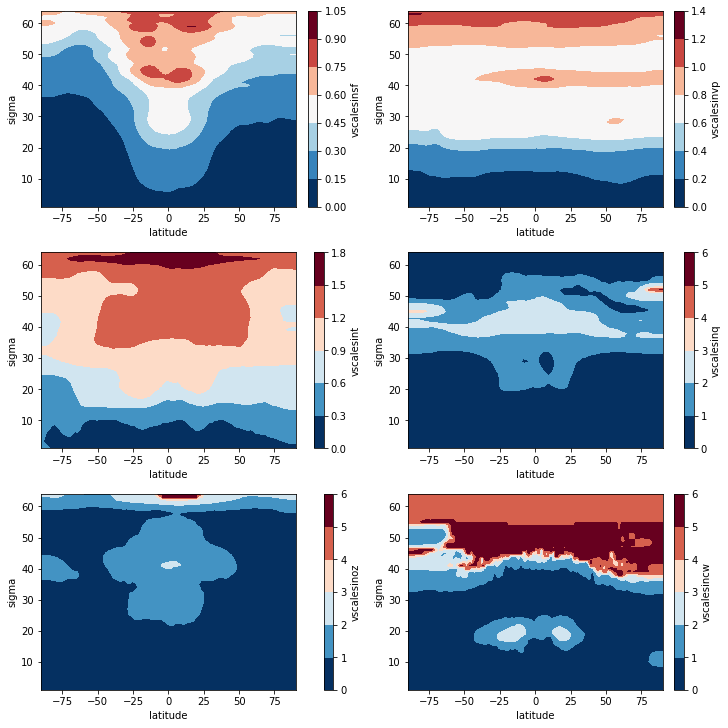

In [15]:
mplot(lvscales, '2d')

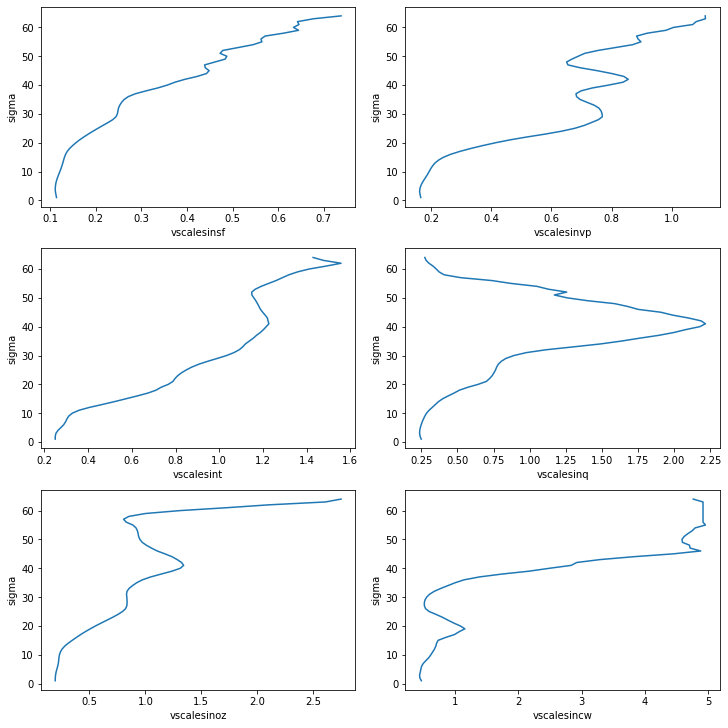

In [16]:
mplot(lvscales, '1d')